## Import libraries

In [50]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.stats import poisson, nbinom

## Load data - exports

In [51]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

In [ ]:
data_long = pd.read_csv(data_path / 'Regions_to_USA.csv')
df = data_long.pivot(index='month', columns='region', values='export_value').reset_index()
df['month'] = pd.to_datetime(df['month'])

KeyError: 'month'

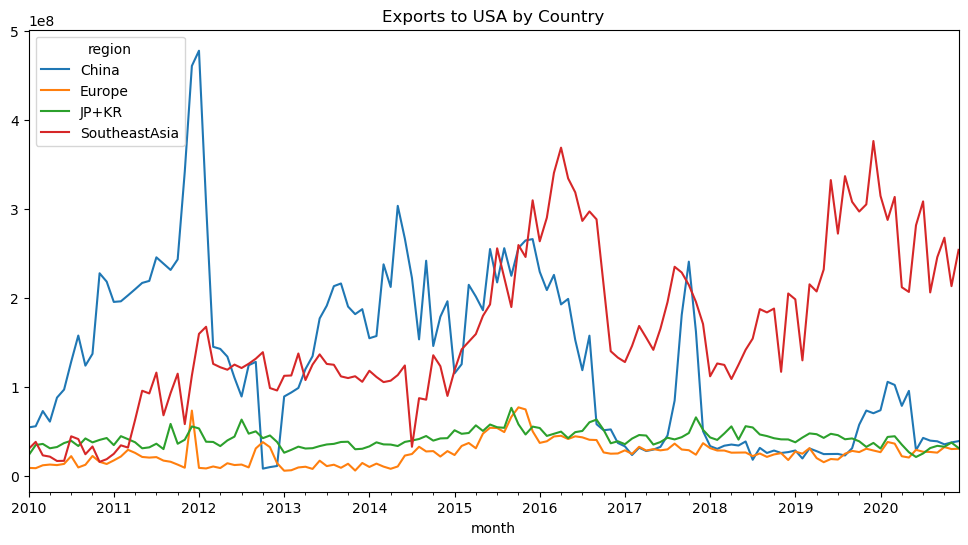

In [53]:
df.set_index('month').plot(figsize=(12, 6), title='Exports to USA by Country')
plt.show()

## Model

In [54]:
# Fill missing values (optional)
df = df.fillna(method='ffill').fillna(method='bfill')

# Normalize the data
df_normalized = df.set_index('month').apply(lambda x: (x - x.min()) / (x.max() - x.min())).reset_index()

df_normalized

C:\Users\cicci\AppData\Local\Temp\ipykernel_21864\1675954835.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


region,month,China,Europe,JP+KR,SoutheastAsia
0,2010-01-01,0.098612,0.044599,0.034193,0.040037
1,2010-02-01,0.101452,0.040022,0.243167,0.062325
2,2010-03-01,0.137786,0.086020,0.265753,0.020231
3,2010-04-01,0.112519,0.097272,0.177118,0.016236
4,2010-05-01,0.169942,0.088583,0.202499,0.002777
...,...,...,...,...,...
127,2020-08-01,0.067014,0.295908,0.181606,0.528140
128,2020-09-01,0.065388,0.285249,0.226678,0.638012
129,2020-10-01,0.058139,0.373314,0.208888,0.698659
130,2020-11-01,0.062738,0.342022,0.292555,0.547651


In [55]:
df_tariffs = pd.DataFrame()
df_tariffs['month'] = df_normalized['month']
df_tariffs

,month
0,2010-01-01
1,2010-02-01
2,2010-03-01
3,2010-04-01
4,2010-05-01
...,...
127,2020-08-01
128,2020-09-01
129,2020-10-01
130,2020-11-01


In [56]:
# Initialize columns
df_tariffs['china tariff'] = 0.0
df_tariffs['eu tariff'] = 0.0
df_tariffs['jp + kr tariff'] = 0.0
df_tariffs['sea tariff'] = 0.0

# Apply tariff values based on date ranges
df_tariffs.loc[df_tariffs['month'] < pd.Timestamp('2012-07-05'), ['china tariff', 'eu tariff', 'jp + kr tariff', 'sea tariff']] = 0.0

df_tariffs.loc[
    (df_tariffs['month'] >= pd.Timestamp('2012-07-05')) & (df_tariffs['month'] < pd.Timestamp('2012-12-01')),
    'china tariff'
] = 0.3463

df_tariffs.loc[
    (df_tariffs['month'] >= pd.Timestamp('2012-12-01')) & (df_tariffs['month'] < pd.Timestamp('2014-12-01')),
    'china tariff'
] = 0.4651

df_tariffs.loc[
    (df_tariffs['month'] >= pd.Timestamp('2014-12-01')) & (df_tariffs['month'] < pd.Timestamp('2018-02-01')),
    'china tariff'
] = 0.9055

df_tariffs.loc[
    (df_tariffs['month'] >= pd.Timestamp('2018-02-01')) & (df_tariffs['month'] < pd.Timestamp('2019-02-01')),
    ['china tariff', 'eu tariff', 'jp + kr tariff', 'sea tariff']
] = 0.30

df_tariffs.loc[
    df_tariffs['month'] >= pd.Timestamp('2019-02-01'),
    ['china tariff', 'eu tariff', 'jp + kr tariff', 'sea tariff']
] = 0.25

    

In [57]:
df_tariffs.head()

,month,china tariff,eu tariff,jp + kr tariff,sea tariff
0,2010-01-01,0.0,0.0,0.0,0.0
1,2010-02-01,0.0,0.0,0.0,0.0
2,2010-03-01,0.0,0.0,0.0,0.0
3,2010-04-01,0.0,0.0,0.0,0.0
4,2010-05-01,0.0,0.0,0.0,0.0


In [58]:
df_tariffs.to_csv(data_path / 'tariffs_final.csv', index=False)

In [59]:
df_tariffs.shape

(132, 5)

## Model

In [60]:
df.head()

region,month,China,Europe,JP+KR,SoutheastAsia
0,2010-01-01,5.485927e+07,9.460980e+06,2.358622e+07,3.064121e+07
1,2010-02-01,5.619061e+07,9.135599e+06,3.511262e+07,3.866245e+07
2,2010-03-01,7.322346e+07,1.240549e+07,3.635841e+07,2.351316e+07
3,2010-04-01,6.137866e+07,1.320538e+07,3.146956e+07,2.207556e+07
4,2010-05-01,8.829792e+07,1.258765e+07,3.286948e+07,1.723182e+07


In [61]:
def lotka_volterra_with_tariffs(t, X,tariffs, r1, r2, r3, r4, 
                                a11, a12, a13, a14,
                                a21, a22, a23, a24,
                                a31, a32, a33, a34,
                                a41, a42, a43, a44,
                                tau):
    X1, X2, X3, X4 = X
    trf1, trf2, trf3, trf4 = tariffs.iloc[int(t), 1:]  

    dx1dt = r1 * X1 * (1 - (1 + tau*trf1)*a11*X1 + (1 - tau*trf2) * a12 * X2 + (1 - tau*trf3) * a13 * X3 + (1 - tau*trf4) * a14 * X4)
    dx2dt = r2 * X2 * (1 - (1 - tau*trf1)*a21*X1 + (1 + tau*trf2) * a22 * X2 + (1 - tau*trf3) * a23 * X3 + (1 - tau*trf4) * a24 * X4)
    dx3dt = r3 * X3 * (1 - (1 - tau*trf1)*a31*X1 + (1 - tau*trf2) * a32 * X2 + (1 + tau*trf3) * a33 * X3 + (1 - tau*trf4) * a34 * X4)
    dx4dt = r4 * X4 * (1 - (1 - tau*trf1)*a41*X1 + (1 - tau*trf2) * a42 * X2 + (1 - tau*trf3) * a43 * X3 + (1 + tau*trf4) * a44 * X4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]


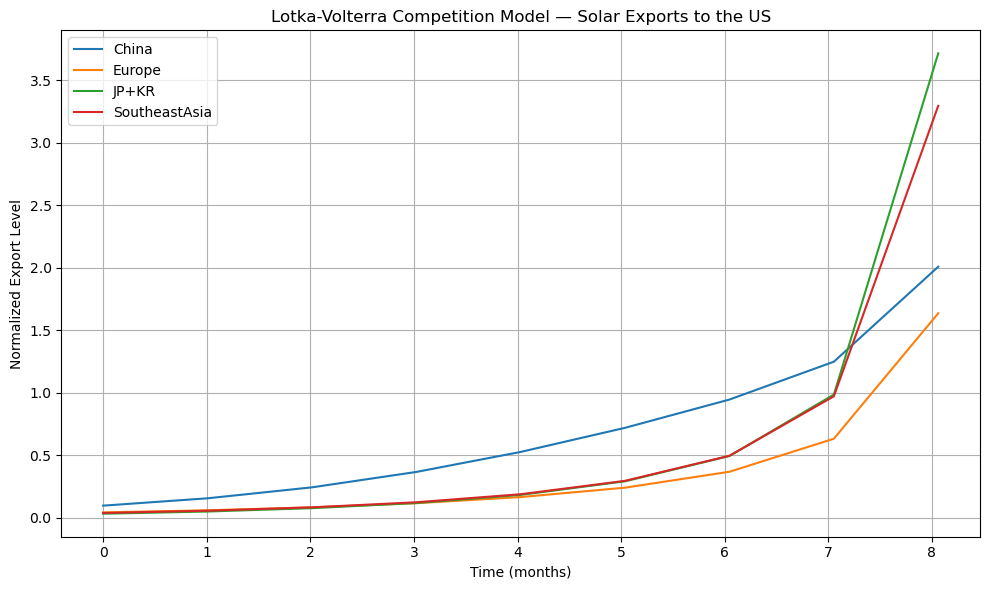

In [62]:
# Parameters (example values, adjust as needed)
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0,
    'tau': 0.1
}

# Initial conditions (example, adjust as needed)
X0 = df_normalized.iloc[0, 1:].values.tolist()  # Use the first row of normalized data as initial conditions

# Time span and evaluation points
t_span = (0, len(df_tariffs))  # From the start to the end of the data
t_eval = np.linspace(*t_span, len(df_tariffs))

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs(t, X, df_tariffs, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Europe')
plt.plot(sol.t, sol.y[2], label='JP+KR')
plt.plot(sol.t, sol.y[3], label='SoutheastAsia')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Calibration - Least Squares

In [63]:
china_data = df_normalized['China']
europe_data = df_normalized['Europe']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jpkr_data, southeastasia_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [64]:
def residuals(params, X0, tariffs, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]
    b11, b12, b13, b14 = params[20:24]
    b21, b22, b23, b24 = params[24:28]
    b31, b32, b33, b34 = params[28:32]
    b41, b42, b43, b44 = params[32:36]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_with_tariffs_end(
            t, X, tariffs, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44,
            b11, b12, b13, b14,
            b21, b22, b23, b24,
            b31, b32, b33, b34,
            b41, b42, b43, b44
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [65]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., b44 (total 36 params)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,   # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.3,    # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.4,    # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.5,    # a31, a32, a33, a34
    0.2, 0.3, 0.4, 1.0,    # a41, a42, a43, a44
    0.1, 0.1, 0.1, 0.1,     # b11, b12, b13, b14
    0.1, 0.1, 0.1, 0.1,     # b21, b22, b23, b24
    0.1, 0.1, 0.1, 0.1,     # b31, b32, b33, b34
    0.1, 0.1, 0.1, 0.1      # b41, b42, b43, b44
]

# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, df_tariffs, t_data, data),
                       bounds=(0, 2))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

NameError: name 'lotka_volterra_with_tariffs_end' is not defined

In [ ]:
fitted_params

array([4.30480592e-01, 2.24053670e-01, 3.74179998e-01, 2.39024255e-01,
       1.25052355e+00, 7.11537310e-01, 2.95829153e-01, 4.39281762e-01,
       4.86276003e-01, 1.12633229e+00, 5.98379802e-01, 4.87603943e-01,
       5.05032338e-01, 2.30282531e-01, 1.00069136e+00, 9.06767938e-01,
       3.45207556e-01, 6.18279549e-01, 6.38586947e-01, 1.27666213e+00,
       2.31670432e-01, 6.04151477e-03, 3.65268475e-04, 1.30405309e-02,
       4.95336942e-05, 8.93874032e-01, 1.54291914e-02, 5.22359878e-02,
       2.36711445e-02, 9.84202166e-02, 1.03539520e+00, 2.50821160e-02,
       6.42619581e-02, 1.15213505e-01, 4.95413550e-02, 3.17168706e-01])

In [ ]:
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

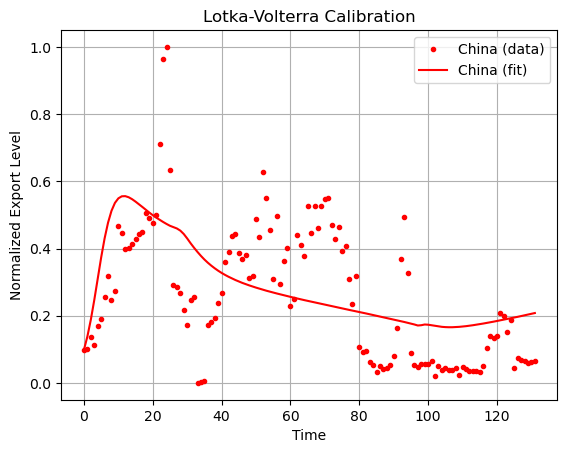

In [ ]:
# Plot
plt.plot(t_data[:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

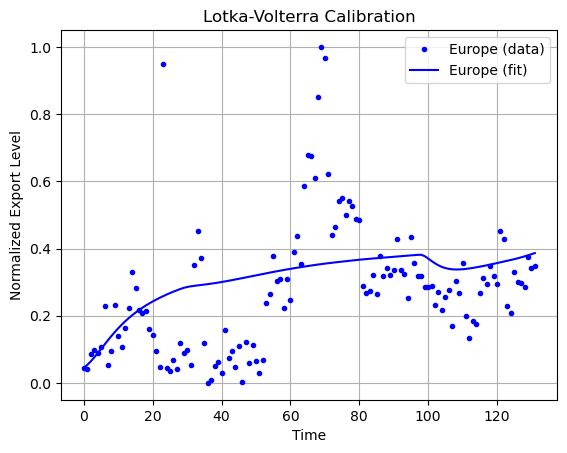

In [ ]:
plt.plot(t_data[:len(data[1])], data[1], 'b.', label='Europe (data)')
plt.plot(t_data, sol.y[1], 'b-', label='Europe (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

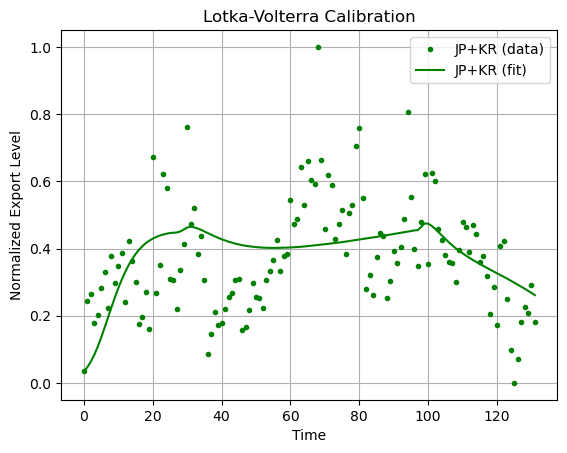

In [ ]:
plt.plot(t_data[:len(data[2])], data[2], 'g.', label='JP+KR (data)')
plt.plot(t_data, sol.y[2], 'g-', label='JP+KR (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

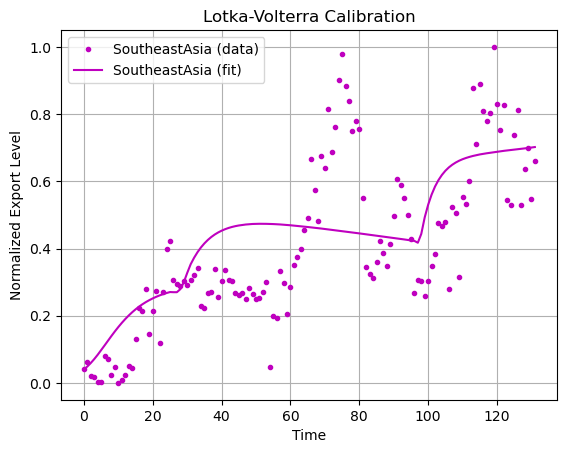

In [ ]:
plt.plot(t_data[:len(data[3])], data[3], 'm.', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[3], 'm-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

## Model Calibration - lkh and llkh

In [ ]:
# Define likelihood 
def compute_likelihood(data, data_mod):
    lkh = np.prod(nbinom.pmf(data,data_mod)) #poisson likelihood to observe the data with a model
    return lkh

# Define log-likelihood 
def compute_loglikelihood(data, data_mod):
    llkh = np.sum(np.log(poisson.pmf(data,data_mod))) #poisson likelihood to observe the data with a model
    return llkh

## Model Calibration - MSE

In [ ]:
china_data = df_normalized['China']
europe_data = df_normalized['Europe']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jpkr_data, southeastasia_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months